## COMP2006: Graded Lab 3

In this lab, you will gain some experience in converting non-numeric features in a dataset to numeric so they can be used in a machine learning model.

**Target**: to predict `Comb Unadj FE - Conventional Fuel`

**Data set**: make sure you use the data assigned to your group!

| Groups | Data set |
| :-: | :-: |
| 1 | veh1.csv |
| 2 | veh2.csv |
| 3 | veh3.csv |
| 4 | veh4.csv |
| 5 | veh5.csv |
| 6 | veh6.csv |
| 7 | veh7.csv |
| 8 | veh8.csv |
| 10 | veh10.csv |

**Important Notes:**
- Use [Chapter 6](https://mlbook.explained.ai/catvars.html) of the textbook as a **guide**:
     - you only need to use **random forest** models;
- Use the **out-of-bag score** to evaluate models
     - Read Section 5.2 carefully so that you use this method properly
     - The oob score that you provide should be the average of 10 runs
- Code submitted for this lab should be:
     - error free
         - to make sure this is the case, before submitting, close all Jupyter notebooks, exit Anaconda, reload the lab notebook and execute all cells
     - final code
         - this means that I don't want to see every piece of code you try as you work through this lab but only the final code; only the code that fulfills the objective

> **Don't make assumptions!**


### Part 0


### Group Number 7
 - Manuel Bishop Noriega - ID 4362207
 - Robert E. Matney III - ID: 4364229

     

### Part 1 - Create and evaluate an initial model

In this part you should: 
 - read in the data
 - isolate all numeric features from original data set
 - verify there are no missing values
 - create and evaluate a baseline model 

#### Code (15 marks)

In [246]:
import pandas as pd
from rfpimp import *
# reading data
# while working this step, to analyze and understand the data
# we used functions such as info, describe, head().T among others.
df = pd.read_csv("veh7.csv")

In [247]:
# isolating numeric data to create our baseline
df_n=df.select_dtypes(include=['number'])
# verifying there's no missing values
df_n.isnull().any()
# splitting features/target datasets
X= df_n.drop('Comb Unadj FE - Conventional Fuel', axis=1)
nFeatures=[col for col in X.columns.tolist()]
y= df_n['Comb Unadj FE - Conventional Fuel']

In [248]:
# to prevent repeating code we'll create an evaluation function called evalute
# it will take features and target as parameters and use them to
# create and fit a random forest regressor model and calculate it's oob performance
# it returns a tuple with rf model and its oob average from 10 runs
def evaluate(X,y):
    from sklearn.ensemble import RandomForestRegressor

    oob_scores = []
    for i in range(20):
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
        rf.fit(X, y)
        oob_scores.append(rf.oob_score_)
    oob=sum(oob_scores) / len(oob_scores)
    print(f'Mean OOB score: {oob}')
    print(f'{rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height')

    return rf, oob
# showimp() show features importances, it accepts up to 4 params
# rf: a randomforest regressor
# X,y are the features and target
# features, I added this to perform different tests while converting non-numeric features
# plots the features' importances graphic
def showimp(rf,X,y):
    I=importances(rf,X,y)
    plot_importances(I,color='blue')

# antes de asumir que toda la data numerica esta limpia y denoiseada, recuerda que puedes evaluar la importancia de los campos mediante permutaciones y otra tecnica que
# en este momento no recuerdo... checa si la medición de la importancia no hace la misma cosa sin tantas molestias.
    
def drop_importances(X,y):
    rf=RandomForestRegressor(n_estimators=100, n_jobs=1, oob_score=True, random_state=999)
    rf.fit(X,y)
    r2=rf.oob_score_
    print(f'Baseline R^2 with no columns dropped: {r2:.5f}\n')
    for col in X.columns:
        X_col=X.copy()
        X_col=X_col.drop(col,axis=1)
        rf.fit(X_col,y)
        r2_col=rf.oob_score_
        print(f'Dropping column {col}: new R^2 is {r2_col:.5f} and difference from baseline is {r2 - r2_col}')

Mean OOB score: 0.8031138779941335
28,482 tree nodes and 14.0 median tree height


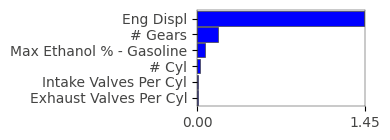

In [249]:
#call our evaluate and showimp functions for our BASELINE MODEL
baseline_model,oob1=evaluate(X,y)
showimp(baseline_model,X,y)

In [250]:
drop_importances(X,y)

Baseline R^2 with no columns dropped: 0.80297

Dropping column Eng Displ: new R^2 is 0.73718 and difference from baseline is 0.06579721796891724
Dropping column # Cyl: new R^2 is 0.80114 and difference from baseline is 0.001836115322496057
Dropping column # Gears: new R^2 is 0.72647 and difference from baseline is 0.07650130269914424
Dropping column Max Ethanol % - Gasoline: new R^2 is 0.77324 and difference from baseline is 0.029732963754217967
Dropping column Intake Valves Per Cyl: new R^2 is 0.80325 and difference from baseline is -0.0002751746480560424
Dropping column Exhaust Valves Per Cyl: new R^2 is 0.80320 and difference from baseline is -0.00022987625368808828


#### Question (5 marks)

Explain the purpose of creating a baseline model. 

**Enter your answer here:**
Purpose of baseline model is to have point of comparison so we can evaluate if our feature engineering improves model's predictive ability. In baseline model we use only numeric features. In this case we built it with cleaned data, that means, after trying to make sure that there are no missing values or other inconsistencies.

We tested dropping some fields like Intake and Exhaust Valves but not appreciable difference was detected.

### Part 2 - Convert non-numeric features to numeric

In this part you should: 
 - convert **all** non-numeric features to numeric
 - one of the conversions should use **one-hot encoding**
 - create **one new feature** by combining 2 or more of the existing features
 
#### Code (25 marks)

In [264]:
nanFeatures=[col for col in df.columns.tolist() if col not in nFeatures +['Comb Unadj FE - Conventional Fuel']]
# nanFeatures.remove('Calc Approach Desc')
df_n=df[nFeatures + nanFeatures]
# converting all non-numeric features to numeric
import category_encoders as ce
encoder = ce.OrdinalEncoder(mapping=[{'col':'Stop/Start System (Engine Management System)  Description', 'mapping': {'No':0, 'Yes':1}},
                                     {'col':'Lockup Torque Converter', 'mapping': {'N':0, 'Y':1}},
                                     {'col':'Cyl Deact?', 'mapping': {'N':0, 'Y':1}},
                                    #  {'col':'Calc Approach Desc', 'mapping': {'Derived 5-cycle label':2, 'Vehicle Specific 5-cycle label':0,
                                    #                                           'Derived Vehicle Specific 5-cycle Calculation Approach for city label but Modified 5-cycle Calculation Approach for Highway label':1}},
                                     {'col':'Trans Creeper Gear', 'mapping': {'N':0, 'Y':1}}])
encoder.fit(df_n)
Xef=encoder.transform(df_n)

# cad=Xef['Calc Approach Desc'].value_counts()
# Xef['cad_count']=Xef['Calc Approach Desc'].map(cad)
# Xef=Xef.drop('Calc Approach Desc', axis=1)
# converting non-numeric feature using one-hot encodig
encoder=ce.OneHotEncoder(cols=['Calc Approach Desc'])
encoder.fit(Xef)
Xef=encoder.transform(Xef)

In [265]:
Xef.head().T

,0,1,2,3,4
Eng Displ,4.7,4.7,4.7,4.7,4.2
# Cyl,8.0,8.0,8.0,8.0,8.0
# Gears,7.0,6.0,7.0,6.0,7.0
Max Ethanol % - Gasoline,10.0,10.0,10.0,10.0,10.0
Intake Valves Per Cyl,2.0,2.0,2.0,2.0,2.0
Exhaust Valves Per Cyl,2.0,2.0,2.0,2.0,2.0
Stop/Start System (Engine Management System) Description,0.0,0.0,0.0,0.0,0.0
Lockup Torque Converter,0.0,0.0,0.0,0.0,1.0
Calc Approach Desc_1,1.0,1.0,1.0,1.0,0.0
Calc Approach Desc_2,0.0,0.0,0.0,0.0,1.0


#### Explanation (25 marks)

Please provide an explanation for each conversion from non-numeric to numeric and state why this conversion is appropriate. Please also provide an explanation of the new feature created.  

**Enter your explanation here:**

### Part 3 - Create and evaluate a final model

In this part you should:
 - create and evaluate a model using all the features from Parts 1 and 2 above 

#### Code (15 marks)

Mean OOB score: 0.8596273656681935
41,086 tree nodes and 16.0 median tree height


c:\Users\manolo\OneDrive - St. Lawrence College\Documents\slc\winter2024\comp2006_python\course-labs\.venv\Lib\site-packages\rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Baseline R^2 with no columns dropped: 0.85652

Dropping column Eng Displ: new R^2 is 0.78485 and difference from baseline is 0.07167115459314033
Dropping column # Cyl: new R^2 is 0.85766 and difference from baseline is -0.0011455192821967497
Dropping column # Gears: new R^2 is 0.82835 and difference from baseline is 0.028173553747927294
Dropping column Max Ethanol % - Gasoline: new R^2 is 0.85406 and difference from baseline is 0.00246332973948038
Dropping column Intake Valves Per Cyl: new R^2 is 0.85753 and difference from baseline is -0.001010033912685282
Dropping column Exhaust Valves Per Cyl: new R^2 is 0.85761 and difference from baseline is -0.0010920201025392817
Dropping column Stop/Start System (Engine Management System)  Description: new R^2 is 0.84493 and difference from baseline is 0.011593240925191317
Dropping column Lockup Torque Converter: new R^2 is 0.84726 and difference from baseline is 0.009261287080466918
Dropping column Calc Approach Desc_1: new R^2 is 0.85660 and d

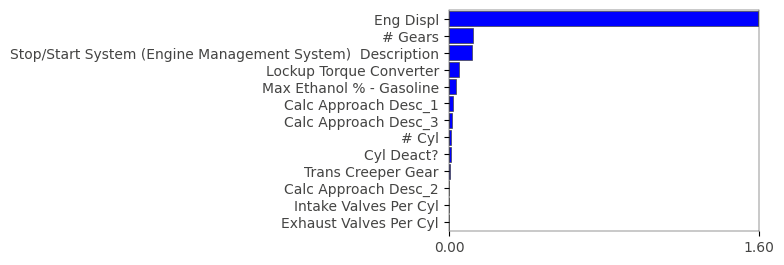

In [266]:
# print(Xef2.info())
# X2=Xef2.drop(['Intake Valves Per Cyl','Exhaust Valves Per Cyl'],axis=1)
#call our evaluate and showimp functions for our ENGINEERED FEATURES MODEL
# Xef=Xef.drop('Calc Approach Desc', axis=1)
ef_model,oob2=evaluate(Xef,y)
showimp(ef_model,Xef,y)
drop_importances(Xef,y)

Mean OOB score: 0.8597321345986598
39,988 tree nodes and 15.0 median tree height


c:\Users\manolo\OneDrive - St. Lawrence College\Documents\slc\winter2024\comp2006_python\course-labs\.venv\Lib\site-packages\rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


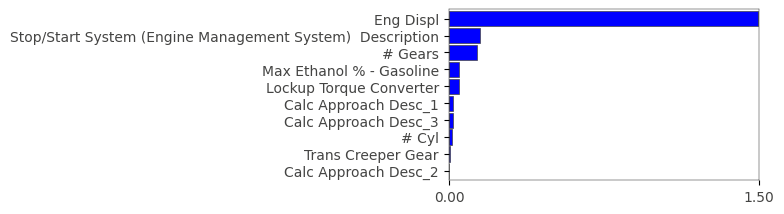

In [267]:
X2=Xef.drop(['Cyl Deact?','Intake Valves Per Cyl','Exhaust Valves Per Cyl'],axis=1)
ef_model2,oob3=evaluate(X2,y)
showimp(ef_model2,X2,y)

In [268]:
drop_importances(X2,y)

Baseline R^2 with no columns dropped: 0.85812

Dropping column Eng Displ: new R^2 is 0.77837 and difference from baseline is 0.07974119596475604
Dropping column # Cyl: new R^2 is 0.85777 and difference from baseline is 0.0003419060662592788
Dropping column # Gears: new R^2 is 0.82444 and difference from baseline is 0.033672357063915914
Dropping column Max Ethanol % - Gasoline: new R^2 is 0.85379 and difference from baseline is 0.004321596576259301
Dropping column Stop/Start System (Engine Management System)  Description: new R^2 is 0.84418 and difference from baseline is 0.013930879365453785
Dropping column Lockup Torque Converter: new R^2 is 0.84722 and difference from baseline is 0.010891408466088048
Dropping column Calc Approach Desc_1: new R^2 is 0.85752 and difference from baseline is 0.0005948419010111117
Dropping column Calc Approach Desc_2: new R^2 is 0.85921 and difference from baseline is -0.0010966883487000256
Dropping column Calc Approach Desc_3: new R^2 is 0.85825 and diff

### Part 4 - Feature importances and comparison (10 marks)

In this part you should:
 - calculate the percent difference between the results of Part 1 and Part 3 (make sure you are using the correct formula for percent difference) 
 - based on the percent difference, state whether or not the results of Part 3 are an improvement over the results of Part 1
 - use the `rfpimp_MC` package to calculate and display the feature importances for all features

#### Question (5 marks)

Based on the feature importances, are any features that you think should be removed from the data set.  Why do you think these features should be removed? 

**Enter your answer here:**